In [302]:
import numpy as np 
import pandas as pd
from haversine import haversine_vector, Unit
import geopandas as gpd
from shapely.geometry import Point, MultiPoint
from shapely.ops import unary_union
import sys

State="NC"
GeneratorDataPath="./EIAData/february_generator2023.xlsx"
HazusDataPath="./HazusData/Hazus_NC_Hurricane.shp"

UserDataPath="./ExcelUserData/"
CensusDataPath="./CensusData/US_tract_cenpop_2020.shp" # https://data2.nhgis.org/downloads


Vintages=np.arange(2022,1900,-1) #Exisiting years. [2022 to 2020), [2020 to 2018) Needs to start from earlier date to later date
FutureYears=[2023]+list(np.arange(2025,2051,5))#2023 to 2050

Seasons=["S1","S2","S3","S4"] # Winter, Spring, Summer, Fall
TimeOfDay=["T1","T2","T3","T4","T5","T6","T7","T8","T9","T10","T11","T12","T13","T14","T15","T16","T17","T18","T19","T20","T21","T22","T23","T24"] # 24 hours of the day, cant be changed


BinaryAggregateonDistance=False # If False, it aggregates on region. If True, it aggregates on distance

AggregationDistance=16#[km], Distance technologies need to be in order to get aggregated with each other 
#Only technologies of the same vintage period, and type will be aggregated



#----- Tasks ------
#1. Build df for ExistingCapacity     -ok
#2. Build df for time_periods         -ok
#3. Build df for time_period_labels   -ok
#4. Build df for time_seasons         -ok
#5. Build df for time_renewable       -ok
#6. Build df for time_of_day          -ok 
#7. Build df for technology_labels    -ok
#8. Build df for sector_labels        -ok
#9. Build df for Demand               -ok
#10.Build df for CostInvestment       -in progress


#----- Tasks next ------
#3. Create Lifetime process
#4. List of plants that get aggregated in each region from the existing capacity

#1. Organize Costs in sql structure
#2. Create Transmission costs

#CapacityFactor
#Emissions
#C02 targets




# Code to Convert Excel Table to Sql data

## ExistingCapacity 


In [303]:
##Generation data from: Preliminary Monthly Electric Generator Inventory (based on Form EIA-860M as a supplement to Form EIA-860)

#Read File
df = pd.read_excel(GeneratorDataPath, sheet_name ='Operating',skiprows=2)
InState=df["Plant State"]==State #Filter for NC
df=df[InState].reset_index()

#NameplateCapacity should be larger than or equal to NetSummerCapacity and NetWinterCapacity
NC=df["Nameplate Capacity (MW)"]
NSC=df["Net Summer Capacity (MW)"]
NWC=df["Net Winter Capacity (MW)"]

df["Nameplate Capacity (MW)"]=np.max(np.vstack((NC,NSC,NWC)),axis=0)

In [304]:
#   Some plants may have multiple generators commissioned at different times
#   we are aggregating the capacity of these generators per year

#   We can have multiple vintages (years) of the same plant. As generators may be comissioned at different times
df_AggregateGen = pd.DataFrame(columns=["PlantID","SourceCode", "MoverCode", "OperatingYear","NameplateCapacity(MW)","NetSummerCapacity(MW)","NetWinterCapacity(MW)",
 "NameplateEnergyCapacity(MWh)", "Latitude","Longitude","Technology"])

for ID in df["Plant ID"].unique().astype(int):
    #Same Plant data
    SameIds   = df["Plant ID"]==ID
    df_tmp1    = df[SameIds]

    SourceCode=df_tmp1["Energy Source Code"]
    #Same Energy Source Code data
    for UniqueSC in SourceCode.unique():
        SameIds    = df_tmp1["Energy Source Code"]==UniqueSC
        df_tmp2    = df_tmp1[SameIds]

        MoverCode=df_tmp2["Prime Mover Code"]
        #Same Mover Code data
        for UniqueMC in MoverCode.unique():
            SameIds    = df_tmp2["Prime Mover Code"]==UniqueMC
            df_tmp3    = df_tmp2[SameIds]

            OperatingYear=df_tmp3["Operating Year"]
            OperatingYear=OperatingYear.sort_values(ascending=False)
            #Same Year Code data
            for UniqueY in OperatingYear.unique():
                
                SameIds    = df_tmp3["Operating Year"]==UniqueY
                df_tmp4    = df_tmp3[SameIds].reset_index()

                if UniqueMC!="BA":
                    NameplateEnergyCapacity=np.sum(df_tmp4["Nameplate Energy Capacity (MWh)"])
                    NameplateCapacity=np.sum(df_tmp4["Nameplate Capacity (MW)"])
                    NetSummerCapacity=np.sum(df_tmp4["Net Summer Capacity (MW)"])
                    NetWinterCapacity=np.sum(df_tmp4["Net Winter Capacity (MW)"])

                    Latitude  = df_tmp4["Latitude"].iloc[0]
                    Longitude = df_tmp4["Longitude"].iloc[0]
                    Technology= df_tmp4["Technology"].iloc[0]

                    NewPlantID = UniqueSC + "_" + UniqueMC + "_" + str(ID) 

                    Data=[[NewPlantID, UniqueSC, UniqueMC, UniqueY, NameplateCapacity, NetSummerCapacity, NetWinterCapacity,NameplateEnergyCapacity,
                    Latitude,Longitude,Technology]]

                    df_AggregateGen=pd.concat([df_AggregateGen,pd.DataFrame(Data,columns=df_AggregateGen.columns)],ignore_index=True)
                else:
                    NameplateEnergyCapacity=df_tmp4["Nameplate Energy Capacity (MWh)"]
                    NameplateCapacity=df_tmp4["Nameplate Capacity (MW)"]
                    NetSummerCapacity=df_tmp4["Net Summer Capacity (MW)"]
                    NetWinterCapacity=df_tmp4["Net Winter Capacity (MW)"]

                    Latitude  = df_tmp4["Latitude"].iloc[0]
                    Longitude = df_tmp4["Longitude"].iloc[0]
                    Technology= df_tmp4["Technology"].iloc[0]

                    NewPlantID = UniqueSC + "_" + UniqueMC + "_" + str(ID) 

                    for k in range(len(df_tmp4)):
                        Data=[[NewPlantID, UniqueSC, UniqueMC, UniqueY, NameplateCapacity.iloc[k], NetSummerCapacity.iloc[k], NetWinterCapacity.iloc[k],
                                NameplateEnergyCapacity.iloc[k],Latitude,Longitude,Technology]]

                        df_AggregateGen=pd.concat([df_AggregateGen,pd.DataFrame(Data,columns=df_AggregateGen.columns)],ignore_index=True)                    

#Delete technologies that are after the maximum vintage period
df_AggregateGen=df_AggregateGen[df_AggregateGen["OperatingYear"]<=np.max(Vintages)]

#Check for missing data
if sum(df_AggregateGen[df_AggregateGen["MoverCode"]=="BA"]["NameplateEnergyCapacity(MWh)"]==' '):
    EliminateIdx=(df_AggregateGen["MoverCode"]=="BA") * (df_AggregateGen["NameplateEnergyCapacity(MWh)"]==' ')
    EliminateId=df_AggregateGen[EliminateIdx]["PlantID"]
    print("Check Battery Data, some elements do not have NameplateEnergyCapacity(MWh) and were removed:\n Plant ID:")
    [print(EliminateId.iloc[i]) for i in range(EliminateId.shape[0])]

    df_AggregateGen=df_AggregateGen[~EliminateIdx]

df_AggregateGen = df_AggregateGen.reset_index(drop=True)

df_AggregateGen.to_excel(UserDataPath+"Temporary_ToHelpBuildDecks/TMP_ExistingCapacity_UniqueTechNameLv1.xlsx")

Check Battery Data, some elements do not have NameplateEnergyCapacity(MWh) and were removed:
 Plant ID:
MWH_BA_64640


### Aggregate per region

In [305]:
shapefile_Hazus = gpd.read_file(HazusDataPath)
Hazus1000=shapefile_Hazus.f1000yr

Region1Idx=Hazus1000>=130 # Cat 4 hurricane and above 130mph
Region2Idx=(Hazus1000>=111)*(Hazus1000<130) # Cat 3 hurricane 111-129mph
Region3Idx=Hazus1000<111 # Cat 1-2 hurricane and bellow 110mph

Region1Data=shapefile_Hazus[Region1Idx].reset_index()
Region2Data=shapefile_Hazus[Region2Idx].reset_index() 
Region3Data=shapefile_Hazus[Region3Idx].reset_index()     

new_polyR1 = unary_union([Region1Data.iloc[j]["geometry"] for j in range(Region1Data.shape[0])])
new_polyR2 = unary_union([Region2Data.iloc[j]["geometry"] for j in range(Region2Data.shape[0])])
new_polyR3 = unary_union([Region3Data.iloc[j]["geometry"] for j in range(Region3Data.shape[0])])

df_AggregateGen["Region"]=''
#Assign region for each generation 

for i in range(df_AggregateGen.shape[0]):
    Latitude=df_AggregateGen.iloc[i]["Latitude"]
    Longitude=df_AggregateGen.iloc[i]["Longitude"]

    if new_polyR1.contains(Point(Longitude,Latitude)):
        df_AggregateGen.at[i,"Region"]='R1'

    elif new_polyR2.contains(Point(Longitude,Latitude)):
        df_AggregateGen.at[i,"Region"]='R2'
    
    elif new_polyR3.contains(Point(Longitude,Latitude)):
        df_AggregateGen.at[i,"Region"]='R3'

    else:
        print("Error")
        break

if sum(df_AggregateGen.Region=='')==0:
    print("All existing generators were properly mapped")
else:
    print("Some generators were no properly mapped to the Hazus data\
    check Hazus and the location of generators")

df_AggregateGen3 = pd.DataFrame(columns=["PlantID", "SourceCode", "MoverCode", "Vintage","NameplateCapacity(MW)","NetSummerCapacity(MW)","NetWinterCapacity(MW)",
"NameplateEnergyCapacity(MWh)","Technology","Region"])


for Region in ["R1","R2","R3"]:

    df_tmp1=df_AggregateGen[df_AggregateGen["Region"]==Region]

    SourceCode=df_tmp1["SourceCode"]
    #Same Energy Source Code data
    for UniqueSC in SourceCode.unique():
        SameIds    = df_tmp1["SourceCode"]==UniqueSC
        df_tmp2    = df_tmp1[SameIds]

        MoverCode=df_tmp2["MoverCode"]
        #Same Mover Code data
        for UniqueMC in MoverCode.unique():
            SameIds    = df_tmp2["MoverCode"]==UniqueMC
            df_tmp3    = df_tmp2[SameIds]
            
            OperatingYear=df_tmp3["OperatingYear"]
            for i in range(len(Vintages[0:-1])):

                IdxsIn=(OperatingYear<=Vintages[i]+(Vintages[0]-Vintages[1])/2) * (OperatingYear>Vintages[i]-(Vintages[0]-Vintages[1])/2)
                if sum(IdxsIn)!=0:
                    if UniqueMC!="BA":
                        df_tmp4    = df_tmp3[IdxsIn].reset_index()    

                        NameplateCapacity=np.sum(df_tmp4["NameplateCapacity(MW)"])
                        NetSummerCapacity=np.sum(df_tmp4["NetSummerCapacity(MW)"])
                        NetWinterCapacity=np.sum(df_tmp4["NetWinterCapacity(MW)"])
                        NameplateEnergyCapacity=np.sum(df_tmp4["NameplateEnergyCapacity(MWh)"])
                        
                        NewPlantID = Region + "_" + UniqueSC + "_" + UniqueMC
                        Technology= df_tmp4["Technology"].iloc[0]

                        Data=[[NewPlantID, UniqueSC, UniqueMC, Vintages[i] ,
                        NameplateCapacity, NetSummerCapacity, NetWinterCapacity, NameplateEnergyCapacity,
                        Technology,Region]]

                        df_AggregateGen3=pd.concat([df_AggregateGen3,pd.DataFrame(Data,columns=df_AggregateGen3.columns)],ignore_index=True)
                    else:
                        #We need to differentiate between the different battery technologies
                        #Consider 1, 2 ,4, 6, 8 ,10h battery
                        df_tmp4=df_tmp3[IdxsIn].reset_index()    
                        HoursOfOperation=df_tmp4["NameplateEnergyCapacity(MWh)"]/df_tmp4["NameplateCapacity(MW)"] #h operation of each battery


                        TmpBrack=[0,1, 2 ,4, 6, 8 ,10]
                        for h_id in range(len(TmpBrack)):
                            
                            IdxInBatteryH= (HoursOfOperation>TmpBrack[i]) * (HoursOfOperation<=TmpBrack[i+1])
                            df_tmp5=df_tmp4[IdxInBatteryH].reset_index()    
                            #if not empty
                            if sum(IdxInBatteryH)!=0:
                                
                                #Need to ajust the power of the battery to match the energy capacity
                                NameplateCapacity=np.sum(df_tmp5["NameplateEnergyCapacity(MWh)"])/TmpBrack[i+1]
                                NetSummerCapacity=NameplateCapacity
                                NetWinterCapacity=NameplateCapacity
                                NameplateEnergyCapacity=TmpBrack[i+1]*NameplateCapacity
                                
                                NewPlantID = Region + "_" + UniqueSC + "_" + UniqueMC +str(TmpBrack[i+1])+"h"
                                Technology= df_tmp5["Technology"].iloc[0]

                                Data=[[NewPlantID, UniqueSC, UniqueMC, Vintages[i] ,
                                NameplateCapacity, NetSummerCapacity, NetWinterCapacity, NameplateEnergyCapacity,
                                Technology,Region]]

                                df_AggregateGen3=pd.concat([df_AggregateGen3,pd.DataFrame(Data,columns=df_AggregateGen3.columns)],ignore_index=True)                                

dfExistingCapacity=df_AggregateGen3

### Plot regions and tech location

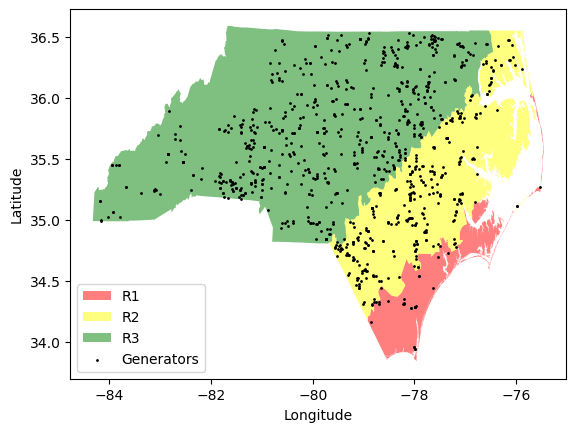

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

count=0
for geom in new_polyR1.geoms:    
    xs, ys = geom.exterior.xy    
    count=count+1
    if count==1:
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none',label="R1")
    else:
        ax.fill(xs, ys, alpha=0.5, fc='r', ec='none')

count=0
for geom in new_polyR2.geoms:    
    count=count+1
    xs, ys = geom.exterior.xy    
    if count==1:
        ax.fill(xs, ys, alpha=0.5, fc='yellow', ec='none',label="R2")
    else:
        ax.fill(xs, ys, alpha=0.5, fc='yellow', ec='none')


xs, ys = new_polyR3.exterior.xy    
ax.fill(xs, ys, alpha=0.5, fc='green', ec='none',label="R3")


plt.scatter(df_AggregateGen["Longitude"],df_AggregateGen["Latitude"],color="black",s=1, label="Generators")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.savefig("RegionsByRisk.png")


### Write df on sql format

In [ ]:
dfExistingCapacity_sql = pd.DataFrame(columns=["regions", "tech", "vintage", "exist_cap", "exist_cap_units", "exist_cap_notes"])
dfExistingCapacity_sql["regions"]=dfExistingCapacity["Region"]
dfExistingCapacity_sql["tech"]=dfExistingCapacity["PlantID"].str.split('_').str[1:3].str.join('_')


dfExistingCapacity_sql["vintage"]=dfExistingCapacity["Vintage"]
dfExistingCapacity_sql["exist_cap"]=dfExistingCapacity["NameplateCapacity(MW)"]/1000 #MW to GW
dfExistingCapacity_sql["exist_cap_units"]="GW"
dfExistingCapacity_sql["exist_cap_notes"]="EIA 860 Generator + Code 2 aggregate"


#Export unique tech name and description to facilitate the manual mapping
data1=dfExistingCapacity_sql["tech"].unique()
data2=[dfExistingCapacity[ dfExistingCapacity["PlantID"].str.split('_').str[1:3].str.join('_')==tech]["Technology"].iloc[0] for tech in dfExistingCapacity_sql["tech"].unique()]

dfExistingCapacity_sql["tech"]=dfExistingCapacity_sql["tech"]+"_Existing"
data1=data1+"_Existing"
data=zip(data1,data2)

ExistingCapacity_UniqueTechNamedf=pd.DataFrame(columns=["tech","description"],data=data)
ExistingCapacity_UniqueTechNamedf.to_excel(UserDataPath + "Temporary_ToHelpBuildDecks/TMP_ExistingCapacity_UniqueTechNameLv2.xlsx",index=False)


## LifetimeTech & LifetimeLoanTech

### Get Energy Capacity With Specific Retirement Dates

In [ ]:
#Read File
df_Retirement = pd.read_excel(UserDataPath+"UserData.xlsx", sheet_name ='LifeTimeSpecific')

for i in range(df_Retirement.shape[0]):
    Latitude=df_Retirement.iloc[i]["Latitude"]
    Longitude=df_Retirement.iloc[i]["Longitude"]

    if new_polyR1.contains(Point(Longitude,Latitude)):
        df_Retirement.at[i,"Region"]='R1'

    elif new_polyR2.contains(Point(Longitude,Latitude)):
        df_Retirement.at[i,"Region"]='R2'
    
    elif new_polyR3.contains(Point(Longitude,Latitude)):
        df_Retirement.at[i,"Region"]='R3'

    else:
        print("Error")
        break
df_Retirement["tech"]=df_Retirement["SourceCode"]+"_"+df_Retirement["MoverCode"] + "_Existing"

In [ ]:
#Aggregate the retirement data (df_AggregateRetirement)
df_AggregateRetirement = pd.DataFrame(columns=["PlantID","SourceCode", "MoverCode", "RetireYear", "NameplateCapacity(MW)","NetSummerCapacity(MW)","NetWinterCapacity(MW)", "Region"])

for Region in ["R1","R2","R3"]:

    df_tmp1=df_Retirement[df_Retirement["Region"]==Region]

    SourceCode=df_tmp1["SourceCode"]
    #Same Energy Source Code data
    for UniqueSC in SourceCode.unique():
        SameIds    = df_tmp1["SourceCode"]==UniqueSC
        df_tmp2    = df_tmp1[SameIds]

        MoverCode=df_tmp2["MoverCode"]
        #Same Mover Code data
        for UniqueMC in MoverCode.unique():
            SameIds    = df_tmp2["MoverCode"]==UniqueMC
            df_tmp3    = df_tmp2[SameIds]
            
            RetireYear=df_tmp3["RetireYear"]
            for RefRetireYear in RetireYear.unique():

                IdxsIn=df_tmp3["RetireYear"]==RefRetireYear
                if sum(IdxsIn)!=0:
                    #So far only considering data for non BA technology
                    if UniqueMC!="BA":
                        df_tmp4    = df_tmp3[IdxsIn]

                        NameplateCapacity=np.sum(df_tmp4["NameplateCapacity(MW)"])
                        NetSummerCapacity=np.sum(df_tmp4["NetSummerCapacity(MW)"])
                        NetWinterCapacity=np.sum(df_tmp4["NetWinterCapacity(MW)"])
                        
                        NewPlantID = Region + "_" + UniqueSC + "_" + UniqueMC + "_Existing"


                        Data=[[NewPlantID, UniqueSC, UniqueMC, RefRetireYear,
                        NameplateCapacity, NetSummerCapacity, NetWinterCapacity,Region]]

                        df_AggregateRetirement=pd.concat([df_AggregateRetirement,pd.DataFrame(Data,columns=df_AggregateRetirement.columns)],ignore_index=True)
                        

### Build a sql for the LifetimeTech & LifetimeLoanTech

In [ ]:
#Read File
df = pd.read_excel(UserDataPath+"UserData.xlsx", sheet_name ='LifeTimesLoanTechDefault')

dfLifetimeTech_sql = pd.DataFrame(columns=["Regions","tech", "life", "life_notes"])
dfLifetimeLoanTech_sql = pd.DataFrame(columns=["Regions","tech", "loan", "loan_notes"])


Regions=["R1"]*len(df)+["R2"]*len(df)+["R3"]*len(df)
tech=np.tile(df["tech"],3)
life=np.tile(df["life tech"],3)
loan=np.tile(df["loan"],3)
Observations=np.tile(df["Observations"],3)

dfLifetimeTech_sql["Regions"]=Regions
dfLifetimeTech_sql["tech"]=tech
dfLifetimeTech_sql["life"]=life
dfLifetimeTech_sql["life_notes"]=Observations

dfLifetimeLoanTech_sql["Regions"]=Regions
dfLifetimeLoanTech_sql["tech"]=tech
dfLifetimeLoanTech_sql["loan"]=loan
dfLifetimeLoanTech_sql["loan_notes"]=Observations

## ExistingCapacity Changes to Match Known Retirements

In [ ]:
# Change the operation year and allocate capacity to match known retirements and LifetimeTech
# On temoa there is only one LifetimeTech value per technology. Since we grouped the technologies part of it 
# may retire at different times. We only know the expected retirements for a few generators (~60%) we need to make sure retirements happen at the right time
dfExistingCapacity_sql_adjusted = dfExistingCapacity_sql.copy()

for i in range(df_Retirement.shape[0]):
    #Retirement data
    OperatingYear=df_Retirement.iloc[i]["OperatingYear"]
    RetireYear=df_Retirement.iloc[i]["RetireYear"]

    Region=df_Retirement.iloc[i]["Region"]
    SourceCode=df_Retirement.iloc[i]["SourceCode"]
    MoverCode=df_Retirement.iloc[i]["MoverCode"]
    tech=df_Retirement.iloc[i]["tech"]
    NameplateCapacity=df_Retirement.iloc[i]["NameplateCapacity(MW)"]/1000 #MW to GW
    NetSummerCapacity=df_Retirement.iloc[i]["NetSummerCapacity(MW)"]/1000 #MW to GW
    NetWinterCapacity=df_Retirement.iloc[i]["NetWinterCapacity(MW)"]/1000 #MW to GW

    #Defined in the sql file is the same for all tehcnologies of the same type
    LifeOfTech=dfLifetimeTech_sql[(dfLifetimeTech_sql["tech"]==tech) * (dfLifetimeTech_sql["Regions"]==Region)]["life"].iloc[0]

    #Check for tech and regions that are the same
    IdxCandidate= (dfExistingCapacity_sql["regions"]==Region) * (dfExistingCapacity_sql["tech"]==tech)
    
    if sum(IdxCandidate)!=0:
        
        #Check for years that are the same of very close
        Targets=(dfExistingCapacity_sql[IdxCandidate]["vintage"]-OperatingYear).abs()
        EC_Av_Discount=np.sum(dfExistingCapacity_sql[IdxCandidate]["exist_cap"][Targets==0]) #Existing capacity available for discount
        
        if EC_Av_Discount>=NameplateCapacity: #a buffer of 2 years between retirements and existing capacity is allowed
            
            NewVintageLocation=RetireYear-LifeOfTech #Year that the resource should be placed to match retirements

            #add
            Data=[[Region,tech, NewVintageLocation, NameplateCapacity, "GW", "New add for retirement ballance"]]
            dfExistingCapacity_sql_adjusted=pd.concat([dfExistingCapacity_sql_adjusted,pd.DataFrame(Data,columns=dfExistingCapacity_sql.columns)],ignore_index=True) 

            #subtract
            Data=[[Region,tech, OperatingYear, -NameplateCapacity, "GW", "New add for retirement ballance"]]
            dfExistingCapacity_sql_adjusted=pd.concat([dfExistingCapacity_sql_adjusted,pd.DataFrame(Data,columns=dfExistingCapacity_sql.columns)],ignore_index=True)            

        else:
            print("Error- Inconsistency between retirements and existing capacity. Not enought capacity on the EIA 860 forms for the target retire")
            print("On Retirement Info: Tech (%s)  OperatingYear (%s)  NameplateCapacity (%s)"%(tech,OperatingYear,NameplateCapacity))
            break


In [300]:
dfExistingCapacity_sql_adjusted_tmp=dfExistingCapacity_sql_adjusted.groupby(["regions","tech","vintage"])["exist_cap"].sum().reset_index()
dfExistingCapacity_sql_adjusted_tmp["exist_cap_units"]="GW"
dfExistingCapacity_sql_adjusted_tmp["exist_cap_notes"]="EIA 860 Generator + Code 2 aggregate"

#Check for negative values
#pop error

#Some vintages may been realocated to match retirements
dfExistingCapacity_sql_adjusted=dfExistingCapacity_sql_adjusted_tmp[dfExistingCapacity_sql_adjusted_tmp["exist_cap"]>0]



In [ ]:
dfExistingCapacity_sql_adjusted_tmp=dfExistingCapacity_sql_adjusted.groupby(["regions","tech","vintage"])["exist_cap"].sum().reset_index()
dfExistingCapacity_sql_adjusted_tmp["exist_cap_units"]="GW"
dfExistingCapacity_sql_adjusted_tmp["exist_cap_notes"]="EIA 860 Generator + Code 2 aggregate"
dfExistingCapacity_sql_adjusted_tmp[dfExistingCapacity_sql_adjusted_tmp["exist_cap"]<=0]

,regions,tech,vintage,exist_cap,exist_cap_units,exist_cap_notes
3,R1,NG_CA_Existing,2013,0.0000,GW,EIA 860 Generator + Code 2 aggregate
5,R1,NG_CT_Existing,2013,0.0000,GW,EIA 860 Generator + Code 2 aggregate
9,R1,NG_GT_Existing,2017,0.0000,GW,EIA 860 Generator + Code 2 aggregate
11,R1,NUC_ST_Existing,1975,0.0000,GW,EIA 860 Generator + Code 2 aggregate
13,R1,NUC_ST_Existing,1977,0.0000,GW,EIA 860 Generator + Code 2 aggregate
51,R2,NG_CA_Existing,2012,0.0000,GW,EIA 860 Generator + Code 2 aggregate
62,R2,NG_GT_Existing,2000,-0.1989,GW,EIA 860 Generator + Code 2 aggregate
82,R3,BIT_ST_Existing,1961,0.0000,GW,EIA 860 Generator + Code 2 aggregate
83,R3,BIT_ST_Existing,1965,0.0000,GW,EIA 860 Generator + Code 2 aggregate
87,R3,BIT_ST_Existing,1969,0.0000,GW,EIA 860 Generator + Code 2 aggregate


In [284]:
dfExistingCapacity_sql_adjusted

,regions,tech,vintage,exist_cap,exist_cap_units,exist_cap_notes
0,R1,DFO_IC_Existing,1991,0.0150,GW,EIA 860 Generator + Code 2 aggregate
1,R1,NUC_ST_Existing,1977,1.0016,GW,EIA 860 Generator + Code 2 aggregate
2,R1,NUC_ST_Existing,1975,1.0016,GW,EIA 860 Generator + Code 2 aggregate
3,R1,NG_GT_Existing,2017,0.1210,GW,EIA 860 Generator + Code 2 aggregate
4,R1,NG_GT_Existing,1995,0.0170,GW,EIA 860 Generator + Code 2 aggregate
...,...,...,...,...,...,...
472,R3,WAT_HY_Existing,1930,-0.0360,GW,New add for retirement ballance
473,R3,WAT_HY_Existing,1914,0.0400,GW,New add for retirement ballance
474,R3,WAT_HY_Existing,1930,-0.0400,GW,New add for retirement ballance
475,R3,WAT_HY_Existing,1914,0.0360,GW,New add for retirement ballance


In [272]:
dfExistingCapacity_sql_adjusted

,regions,tech,vintage,exist_cap,exist_cap_units,exist_cap_notes
0,R1,DFO_IC_Existing,1991,0.0150,GW,EIA 860 Generator + Code 2 aggregate
1,R1,NUC_ST_Existing,1977,1.0016,GW,EIA 860 Generator + Code 2 aggregate
2,R1,NUC_ST_Existing,1975,1.0016,GW,EIA 860 Generator + Code 2 aggregate
3,R1,NG_GT_Existing,2017,0.1210,GW,EIA 860 Generator + Code 2 aggregate
4,R1,NG_GT_Existing,1995,0.0170,GW,EIA 860 Generator + Code 2 aggregate
...,...,...,...,...,...,...
472,R3,WAT_HY_Existing,1930,-0.0360,GW,New add for retirement ballance
473,R3,WAT_HY_Existing,1914,0.0400,GW,New add for retirement ballance
474,R3,WAT_HY_Existing,1930,-0.0400,GW,New add for retirement ballance
475,R3,WAT_HY_Existing,1914,0.0360,GW,New add for retirement ballance


## Demand

### Get Population at Each Region

In [41]:
#For demand we get total energy demand of the sate from the IRPs
#and allocate the demand to R1, R2, R3 based on the population of each region
shapefile_Pop = gpd.read_file(CensusDataPath)
PointsPop=[Point(shapefile_Pop["LONGITUDE"][i],shapefile_Pop["LATITUDE"][i]) for i in range(len(shapefile_Pop))]
PopulationR1=0
PopulationR2=0
PopulationR3=0

for i in range(len(PointsPop)):
    point=PointsPop[i]

    if new_polyR1.contains(point):
        PopulationR1=PopulationR1+shapefile_Pop["POPULATION"][i]
        
    elif new_polyR2.contains(point):
        PopulationR2=PopulationR2+shapefile_Pop["POPULATION"][i]

    elif new_polyR3.contains(point):
        PopulationR3=PopulationR3+shapefile_Pop["POPULATION"][i]

### Read Demand From User and Regionalize

In [42]:
#Read from excel
NonRegionalizedDemand_df = pd.read_excel(UserDataPath+"UserData.xlsx", sheet_name ='Demand')

#Get demand in each region
DemandR1=PopulationR1/(PopulationR1+PopulationR2+PopulationR3)*NonRegionalizedDemand_df["Demand [PJ]"]
DemandR2=PopulationR2/(PopulationR1+PopulationR2+PopulationR3)*NonRegionalizedDemand_df["Demand [PJ]"]
DemandR3=PopulationR3/(PopulationR1+PopulationR2+PopulationR3)*NonRegionalizedDemand_df["Demand [PJ]"]

#Filter for the future years
DemandR1=DemandR1[np.searchsorted(NonRegionalizedDemand_df["periods"], FutureYears)]
DemandR2=DemandR2[np.searchsorted(NonRegionalizedDemand_df["periods"], FutureYears)]
DemandR3=DemandR3[np.searchsorted(NonRegionalizedDemand_df["periods"], FutureYears)]


#Create sql dataframe
Demand_sql = pd.DataFrame(columns=["regions", "periods", "demand_comm", "demand", "demand_units", "demand_notes"])

Demand_sql["regions"]=["R1"]*len(FutureYears)+["R2"]*len(FutureYears)+["R3"]*len(FutureYears)
Demand_sql["periods"]=np.tile(FutureYears,3)
Demand_sql["demand"]=np.concatenate((DemandR1,DemandR2,DemandR3),axis=0)

Demand_sql["demand_units"]="PJ"
Demand_sql["demand_comm"]="ELCD" #Electricity demand
Demand_sql["demand_notes"]=NonRegionalizedDemand_df["Comments"][0]


## time (_of_day, _period_labels, _periods, _renewable, _season)

In [45]:
#time_of_day
time_of_day_sql=pd.DataFrame(columns=["t_day"])
time_of_day_sql["t_day"]=TimeOfDay

#time_period_labels
time_period_labels_sql=pd.DataFrame(columns=["t_period_labels","t_periods_labels_desc"])
time_period_labels_sql["t_period_labels"]=["e","f"]
time_period_labels_sql["t_periods_labels_desc"]=["existing vintages","future"]

#time_periods
time_periods_sql=pd.DataFrame(columns=["t_periods","flag"])
Exisist=Vintages[0:np.where(Vintages==dfExistingCapacity_sql["vintage"].min())[0][0]]
Exisist=Exisist[::-1]
Fut=FutureYears
Periods=np.concatenate((Exisist,Fut))

time_periods_sql["t_periods"]=Periods
time_periods_sql.loc[time_periods_sql["t_periods"]<=dfExistingCapacity_sql["vintage"].max(),"flag"]="e"
time_periods_sql.loc[time_periods_sql["t_periods"]>dfExistingCapacity_sql["vintage"].max(),"flag"]="f"

#time_renewable (Empty)
time_renewable_sql=pd.DataFrame(columns=["Field1"])

#time_season
time_of_day_sql=pd.DataFrame(columns=["t_season"])
time_of_day_sql["t_season"]=Seasons

## sector_labels, technology_labels

In [12]:
#sector_labels
sector_labels_sql=pd.DataFrame(columns=["sector"])
sector_labels_sql["sector"]=["supply","electric","electric_misc","transport","commercial", "residential","industrial"]

In [13]:
technology_labels_sql=pd.DataFrame(columns=["tech_labels","tech_labels_desc"])
technology_labels_sql["tech_labels"]=["r","p","pb","ps"]
technology_labels_sql["tech_labels_desc"]=["resource technology","production technology","baseload production technology","storage production technology"]

## technologies

In [51]:
#Read from excel
technologies_sql = pd.read_excel(UserDataPath+"UserData.xlsx", sheet_name ='technologies')

# #verify content
if set(technologies_sql.columns)!=(set(["tech", "flag", "sector", "tech_desc", "tech_category"])):
    print("Error: There are heads in the technologies sheet not valid")
    print("Look at the path: " + UserDataPath+"UserData.xlsx")
    sys.exit()

if set(technologies_sql["flag"].unique()).issubset(set(technology_labels_sql["tech_labels"]))!=True:
    print("Error: There are elements flag in the technologies sheet not valid")
    print("Look at the path: " + UserDataPath+"UserData.xlsx")
    sys.exit()

if set(technologies_sql["sector"].unique()).issubset(set(sector_labels_sql["sector"]))!=True:
    print("Error: There are elements sector in the technologies sheet not valid")
    print("Look at the path: " + UserDataPath+"UserData.xlsx")
    sys.exit()

## CostInvest

In [15]:
#Error if there are technologies without cost values
#If a cost is not specified for a certain vintage, the value is interpolated from existing vintages
#If a region is not specified in a technology cost all regions with the technology will have the same cost

technologies_sql = pd.read_excel(UserDataPath+"UserData.xlsx", sheet_name ='CostInvest')







In [54]:
dfExistingCapacity_sql[dfExistingCapacity_sql["tech"]=="DFO_IC"]

,regions,tech,vintage,exist_cap,exist_cap_units,exist_cap_notes
0,R1,DFO_IC,1991,0.0150,GW,EIA 860 Generator + Code 2 aggregate
48,R2,DFO_IC,2015,0.0004,GW,EIA 860 Generator + Code 2 aggregate
49,R2,DFO_IC,2014,0.0012,GW,EIA 860 Generator + Code 2 aggregate
50,R2,DFO_IC,2013,0.0092,GW,EIA 860 Generator + Code 2 aggregate
51,R2,DFO_IC,2003,0.0012,GW,EIA 860 Generator + Code 2 aggregate
52,R2,DFO_IC,1999,0.0010,GW,EIA 860 Generator + Code 2 aggregate
53,R2,DFO_IC,1998,0.0135,GW,EIA 860 Generator + Code 2 aggregate
54,R2,DFO_IC,1995,0.0054,GW,EIA 860 Generator + Code 2 aggregate
55,R2,DFO_IC,1994,0.0014,GW,EIA 860 Generator + Code 2 aggregate
56,R2,DFO_IC,1993,0.0120,GW,EIA 860 Generator + Code 2 aggregate
